In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_validate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df=pd.read_csv('final_data.csv')

### Basic Info about the dataset

In [3]:
df.shape

(90739, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90739 entries, 0 to 90738
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  90739 non-null  int64  
 1   date        90739 non-null  object 
 2   1. open     90739 non-null  float64
 3   2. high     90739 non-null  float64
 4   3. low      90739 non-null  float64
 5   4. close    90739 non-null  float64
 6   5. volume   90739 non-null  float64
 7   symbol      90739 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 5.5+ MB


In [5]:
print(f'The number of stocks in the dataset {df['symbol'].nunique()} \nThe stocks are {df['symbol'].unique().tolist()}')

The number of stocks in the dataset 18 
The stocks are ['ADANIENT.BSE', 'APOLLOHOSP.BSE', 'ASIANPAINT.BSE', 'BAJFINANCE.BSE', 'BHARTIARTL.BSE', 'BPCL.BSE', 'BRITANNIA.BSE', 'CIPLA.BSE', 'COALINDIA.BSE', 'DIVISLAB.BSE', 'DRREDDY.BSE', 'HCLTECH.BSE', 'HEROMOTOCO.BSE', 'ITC.BSE', 'KOTAKBANK.BSE', 'RELIANCE.BSE', 'TITAN.BSE', 'WIPRO.BSE']


In [6]:
df.describe()

,Unnamed: 0,1. open,2. high,3. low,4. close,5. volume
count,90739.000000,90739.000000,90739.000000,90739.000000,90739.000000,9.073900e+04
mean,45369.000000,1328.505413,1345.001480,1310.595274,1327.219514,8.917785e+05
std,26194.237375,4913.582846,4918.407461,4908.467142,4913.287721,1.000301e+07
min,0.000000,4.592800,5.337400,4.592800,5.294200,0.000000e+00
25%,22684.500000,353.900000,358.799900,348.050000,353.350000,4.975550e+04
50%,45369.000000,724.000000,734.900000,712.000000,722.800000,1.941180e+05
75%,68053.500000,1691.075000,1713.597100,1668.550000,1690.425000,6.258060e+05
max,90738.000000,999999.999900,999999.999900,999999.999900,999999.999900,1.604368e+09


In [7]:
df.sample(5)

,Unnamed: 0,date,1. open,2. high,3. low,4. close,5. volume,symbol
79716,21236,2022-09-09,2363.3332,2363.6052,2325.6602,2328.9243,331676.0,RELIANCE.BSE
68220,82494,2017-08-07 00:00:00,266.2033,267.4305,263.8906,264.3154,601847.0,ITC.BSE
52782,67210,2017-04-19 00:00:00,2635.0000,2638.0000,2606.4500,2611.3000,104715.0,DRREDDY.BSE
45853,63896,2009-12-14 00:00:00,666.0000,668.0000,651.0000,654.2500,67308.0,DIVISLAB.BSE
10835,19878,2007-06-01,839.0000,874.9500,831.0500,868.6500,215140.0,ASIANPAINT.BSE


Now since the dataset consists of 18 different stocks. we can't casually split the dataset or use cross val on it as it might lead to data leakage.
We have to split the dataset using the groupby function of pandas.
The dataset should be grouped by the STOCK, and for the group, we have to use the first 80% of the time series to train the LSTM and the last 20% to test it.

In [8]:
# import matplotlib.pyplot as plt

# symbols = sorted(df['symbol'].unique())
# fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(20, 24))
# axes = axes.flatten()  # Flatten for easy looping

# for i, symbol in enumerate(symbols):
#     stock_df = df[df['symbol'] == symbol].sort_values('date')

#     ax = axes[i]
#     ax.plot(stock_df['date'], stock_df['4. close'], color='blue')
#     ax.set_title(symbol)
#     ax.set_xlabel("Date")
#     ax.set_ylabel("Close Price (INR)")
#     ax.grid(True)


# plt.tight_layout()
# plt.show()


In [9]:
#renaming the columns
df.rename(columns={'1. open':'open','2. high':'high','3. low':'low','4. close':'close','5. volume':'volume'},inplace=True)

In [10]:
df=df.iloc[:,1:]

In [11]:
# indx=5119
# row=df.iloc[indx:indx+1,:]
# row_before=df.iloc[indx-1:indx,:]
# row_after=df.iloc[indx+1:indx+2,:]
# #error found so will rectify

In [12]:
# print(row_before)
# print(row)
# print(row_after)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90739 entries, 0 to 90738
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    90739 non-null  object 
 1   open    90739 non-null  float64
 2   high    90739 non-null  float64
 3   low     90739 non-null  float64
 4   close   90739 non-null  float64
 5   volume  90739 non-null  float64
 6   symbol  90739 non-null  object 
dtypes: float64(5), object(2)
memory usage: 4.8+ MB


Each stock’s target column aligns with its own next day’s close.

The final row per stock will have NaN as target (which is correct — no “next day” exists).

In [14]:
df = df.sort_values(['symbol', 'date'])
df['target'] = df.groupby('symbol')['close'].shift(-1)


In [15]:
df.shape

(90739, 8)

In [16]:
df.sample(10)

,date,open,high,low,close,volume,symbol,target
48438,2020-06-18 00:00:00,2329.800,2331.9500,2298.1500,2310.7500,8582.0,DIVISLAB.BSE,2301.5000
52974,2018-01-24 00:00:00,2510.000,2611.8000,2510.0000,2561.8500,617510.0,DRREDDY.BSE,2504.0000
46556,2012-10-15 00:00:00,1148.000,1165.0000,1135.4500,1139.1000,34670.0,DIVISLAB.BSE,1122.1500
39755,2020-12-07 00:00:00,767.500,782.3000,767.1500,772.4500,194731.0,CIPLA.BSE,765.9000
39506,2019-12-06 00:00:00,465.000,466.8000,454.0000,455.6000,31058.0,CIPLA.BSE,447.7500
81881,2010-09-13,2962.000,3005.0000,2930.0000,2976.6500,515860.0,TITAN.BSE,3099.8500
37514,2011-10-24 00:00:00,289.000,290.7000,287.8500,289.1500,38886.0,CIPLA.BSE,290.5000
68799,2019-12-18 00:00:00,228.444,233.3527,226.4616,231.4647,439245.0,ITC.BSE,230.6623
15371,2005-01-24,129.900,130.0000,127.6000,128.0000,433250.0,BAJFINANCE.BSE,129.3500
34496,2020-05-20 00:00:00,3114.900,3157.8500,3108.5500,3128.8000,11432.0,BRITANNIA.BSE,3109.5500


In [17]:
# for symbol,group in df.groupby('symbol'):
#   sample=group.tail(2)
#   print(symbol)
#   print(sample[['date', 'close', 'target']])
  # print()
# Now every stock has a NaN at the end cause there is no next date
df.dropna(subset=['target'], inplace=True)
for symbol,group in df.groupby('symbol'):
  sample=group.tail(2)
  print(symbol)
  print(sample[['date', 'close', 'target']])
  print()
#Now there is no NaN cause it's been dropped

ADANIENT.BSE
            date   close   target
5116  2025-10-10  2550.6  2526.70
5117  2025-10-13  2526.7  2516.05

APOLLOHOSP.BSE
             date    close   target
10236  2025-10-13  7675.40  7754.05
10237  2025-10-14  7754.05  7824.65

ASIANPAINT.BSE
             date    close   target
15354  2025-10-10  2340.30  2345.25
15355  2025-10-13  2345.25  2316.70

BAJFINANCE.BSE
             date    close   target
20472  2025-10-10  1023.70  1037.25
20473  2025-10-13  1037.25  1018.60

BHARTIARTL.BSE
                      date    close  target
25592  2025-10-13 00:00:00  1955.05  1946.2
25593  2025-10-14 00:00:00  1946.20  1969.2

BPCL.BSE
             date   close  target
30711  2025-10-10  338.70  337.95
30712  2025-10-13  337.95  332.40

BRITANNIA.BSE
                      date    close  target
35830  2025-10-13 00:00:00  5868.45  5794.5
35831  2025-10-14 00:00:00  5794.50  5856.7

CIPLA.BSE
                      date   close  target
40952  2025-10-13 00:00:00  1563.9  1553.1
40953  20

In [18]:
SEQ_LENGTH=100
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error,root_mean_squared_error,mean_squared_error

In [19]:
# Now actually splitting each stock into 80/20 splits 80 being the training and 20 being the test

train_list, test_list = [], []
for symbol, group in df.groupby('symbol'):
    split_idx = int(len(group) * 0.8)
    train_list.append(group.iloc[:split_idx])
    test_list.append(group.iloc[split_idx:])

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)


In [20]:
train_df.shape


(72570, 8)

In [21]:
test_df.shape

(18151, 8)

In [22]:
print(f'train df split:\n{train_df.groupby('symbol').size()}\n\ntest df split:\n{test_df.groupby('symbol').size()}')

train df split:
symbol
ADANIENT.BSE      4094
APOLLOHOSP.BSE    4095
ASIANPAINT.BSE    4093
BAJFINANCE.BSE    4093
BHARTIARTL.BSE    4095
BPCL.BSE          4094
BRITANNIA.BSE     4094
CIPLA.BSE         4096
COALINDIA.BSE     2943
DIVISLAB.BSE      4096
DRREDDY.BSE       4096
HCLTECH.BSE       4095
HEROMOTOCO.BSE    4095
ITC.BSE           4095
KOTAKBANK.BSE     4096
RELIANCE.BSE      4094
TITAN.BSE         4094
WIPRO.BSE         4112
dtype: int64

test df split:
symbol
ADANIENT.BSE      1024
APOLLOHOSP.BSE    1024
ASIANPAINT.BSE    1024
BAJFINANCE.BSE    1024
BHARTIARTL.BSE    1024
BPCL.BSE          1024
BRITANNIA.BSE     1024
CIPLA.BSE         1025
COALINDIA.BSE      736
DIVISLAB.BSE      1024
DRREDDY.BSE       1025
HCLTECH.BSE       1024
HEROMOTOCO.BSE    1024
ITC.BSE           1024
KOTAKBANK.BSE     1024
RELIANCE.BSE      1024
TITAN.BSE         1024
WIPRO.BSE         1029
dtype: int64


In [23]:
train_df

,date,open,high,low,close,volume,symbol,target
0,2005-01-03,7.5377,7.5906,7.4128,7.4801,1265140.0,ADANIENT.BSE,7.4224
1,2005-01-04,7.5713,7.5713,7.3792,7.4224,1197010.0,ADANIENT.BSE,7.1582
2,2005-01-05,7.3792,7.3888,6.9180,7.1582,1112378.0,ADANIENT.BSE,7.0477
3,2005-01-06,7.1582,7.2302,6.7931,7.0477,1112474.0,ADANIENT.BSE,7.0717
4,2005-01-07,7.2543,7.2543,6.9996,7.0717,1019230.0,ADANIENT.BSE,7.1630
...,...,...,...,...,...,...,...,...
89704,2021-08-12 00:00:00,602.9000,608.6500,600.9000,605.8500,316720.0,WIPRO.BSE,615.5000
89705,2021-08-13 00:00:00,606.7000,620.3500,606.1500,615.5000,12271708.0,WIPRO.BSE,614.0500
89706,2021-08-16 00:00:00,617.5000,620.9500,610.4000,614.0500,520230.0,WIPRO.BSE,634.8000
89707,2021-08-17 00:00:00,614.0000,636.8000,611.6500,634.8000,1407072.0,WIPRO.BSE,629.2000


In [27]:
scaler = StandardScaler()
le = LabelEncoder()
train_df = train_df.sort_values(['symbol', 'date']).reset_index(drop=True)
test_df  = test_df.sort_values(['symbol', 'date']).reset_index(drop=True) #sorting

train_df['symbol_encoded'] = le.fit_transform(train_df['symbol'])
test_df['symbol_encoded']  = le.transform(test_df['symbol'])

scaler.fit(train_df.drop(columns=['date', 'target','symbol'])) #scaling
train_scaled = scaler.transform(train_df.drop(columns=['date', 'target','symbol']))
test_scaled  = scaler.transform(test_df.drop(columns=['date', 'target','symbol']))

train_df_scaled = train_df.copy()
train_df_scaled.loc[:, train_df_scaled.columns.difference(['date', 'target','symbol'])] = train_scaled
test_df_scaled = test_df.copy()
test_df_scaled.loc[:, test_df_scaled.columns.difference(['date', 'target','symbol'])] = test_scaled

x_train, y_train, x_test, y_test = [], [], [], []
for symbol in train_df['symbol_encoded'].unique():
    # ---- TRAIN ----
    train_grp = train_df_scaled[train_df['symbol_encoded'] == symbol]
    X_arr = train_grp.drop(columns=['date', 'target']).values
    y_arr = train_grp['target'].values

    for i in range(len(train_grp) - SEQ_LENGTH):
        x_train.append(X_arr[i:i+SEQ_LENGTH])
        y_train.append(y_arr[i+SEQ_LENGTH])

    # ---- TEST ----
    test_grp = test_df_scaled[test_df['symbol_encoded'] == symbol]
    X_arr = test_grp.drop(columns=['date', 'target']).values
    y_arr = test_grp['target'].values

    for i in range(len(test_grp) - SEQ_LENGTH):
        x_test.append(X_arr[i:i+SEQ_LENGTH])
        y_test.append(y_arr[i+SEQ_LENGTH])

# Convert to numpy arrays
X_train, y_train = np.array(x_train), np.array(y_train)
X_test, y_test   = np.array(x_test), np.array(y_test)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:",  X_test.shape)
print("y_test:",  y_test.shape)


C:\Users\fortn\AppData\Local\Temp\ipykernel_800\4023027605.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.02062433  0.01446021  0.00680307 ... -0.04677198  0.03346574
 -0.05118829]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train_df_scaled.loc[:, train_df_scaled.columns.difference(['date', 'target','symbol'])] = train_scaled
C:\Users\fortn\AppData\Local\Temp\ipykernel_800\4023027605.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.07796559 -0.05438217 -0.07792514 ... -0.07093453 -0.0743195
 -0.06931773]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  test_df_scaled.loc[:, test_df_scaled.columns.difference(['date', 'target','symbol'])] = test_scaled


X_train: (70770, 100, 7)
y_train: (70770,)
X_test: (16351, 100, 7)
y_test: (16351,)


In [33]:
import pickle

target_scaler = StandardScaler()
train_df['target_scaled'] = target_scaler.fit_transform(train_df[['target']])
with open('target_scaler.pkl', 'wb') as f:
    pickle.dump(target_scaler, f)


In [29]:
import pickle
with open('Standard_scaler.pkl','wb') as f1:
    pickle.dump(scaler,f1)
with open('Label_encoder.pkl','wb') as f2:
    pickle.dump(le,f2)
    
    

Now for the building model part

In [85]:
model=Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),

    LSTM(64, return_sequences=False),
    Dropout(0.2),

    Dense(32,activation='relu'),
    Dropout(0.2),

    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100, 128)       │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,153 (473.25 KB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
import tensorflow as tf

In [87]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=True
)

Epoch 1/60
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 12461211.0000 - val_loss: 6946253.0000
Epoch 2/60
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 53500588.0000 - val_loss: 7129637.0000
Epoch 3/60
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 36513348.0000 - val_loss: 3824476.7500
Epoch 4/60
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 38348948.0000 - val_loss: 2067381.7500
Epoch 5/60
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 9466134.0000 - val_loss: 1581612.6250
Epoch 6/60
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 18943208.0000 - val_loss: 796587.3125
Epoch 7/60
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 20988812.0000 - val_loss: 566017.0625
Epoch 8/60
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 50848172.0000 - val_loss: 310086.0938
Epoch 9/60
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 94582968.0000 - val_loss: 227084.0156
Epoch 10/60
1106/1106 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 63961352.0000

511/511 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


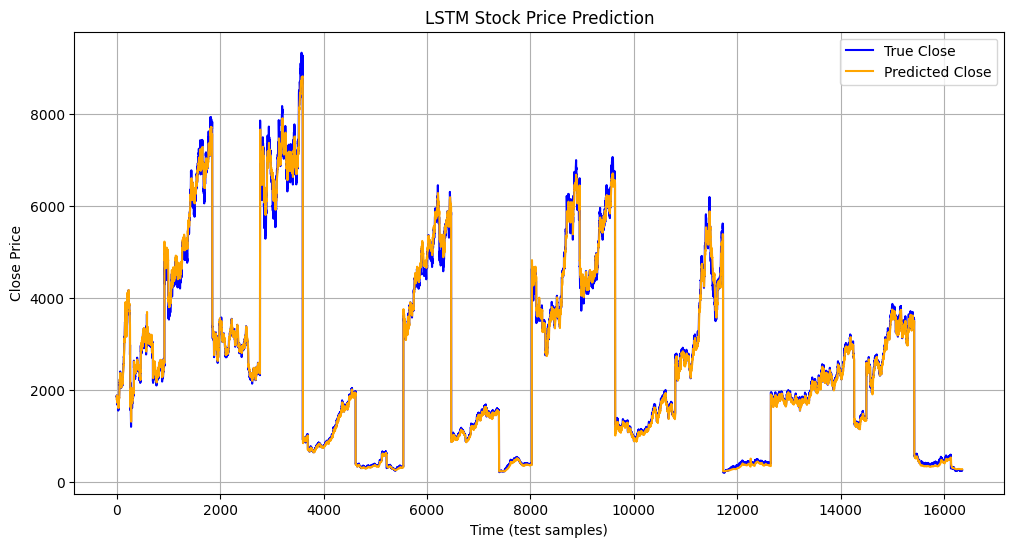

In [88]:
preds = model.predict(X_test)

plt.figure(figsize=(12,6))
plt.plot(y_test, label='True Close', color='blue')
plt.plot(preds, label='Predicted Close', color='orange')
plt.title('LSTM Stock Price Prediction')
plt.xlabel('Time (test samples)')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [90]:
mse = mean_squared_error(y_test, preds)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, preds)

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")


MSE: 25413.9542
RMSE: 159.4175
MAPE: 0.0423


In [91]:
import pickle
import os
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)
